# Introduction

The fact that the Porto Seguro competition is a binary classification task (the customer filed a claim or did not) makes it an excellent opportunity to brush up on two fundamental modelling and evaluation tasks for binary classifiers:

1. Logistic Regression
2. The ROC curve

Logistic regression is a derivative of linear regression where we are interested in making binary predictions or probability predictions on the interval [0, 1] with a threshold probability to determine where we split between 0 and 1. 
The ROC curve or "receiver operating characteristic" curve is an evaluation method we can use to assess the efficacy of a binary classification algorithm ("Receiver Operating Characteristic", n.d.) as well as choose the optimal threshold based on our tolerance for false negatives and desire for true positives. 

# A Simple Example

In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(verification))
library(repr)

options(repr.plot.height = 5, repr.plot.width = 6)

 Before we dig into the Porto data set, let's refresh our memory and take in some theory using  very contrived data. Let's say that we have a small data set on insurance claims consisting of only two variables - a binary variable (0 or 1) indicating whether or not a driver filed a claim and a driver age variable. This fake data set will be quite small for illustrative purposes.

In [2]:
# generate fake insurance dataset
set.seed(12)
insurance <- data.frame(
    claim = c(rep(1, 20), rep(0, 20)),
    age = c(rnorm(20, mean = 25, sd = 5), rnorm(20, mean = 37, sd = 7)))

Let's see what these data look like when plotted:

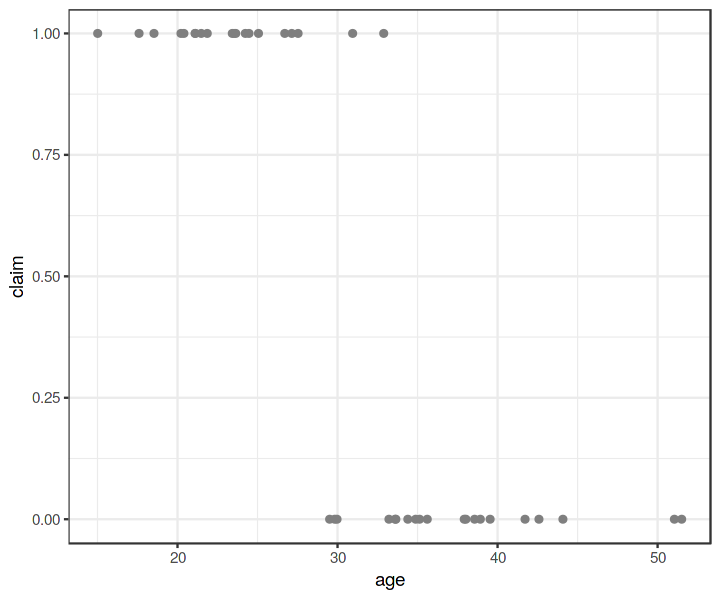

In [3]:
# plot the insurance data
ggplot(data = insurance, aes(x = age, y = claim)) +
    geom_point(color = 'grey50') + 
    theme_bw()

From this plot we can see that those at the younger end of the age spectrum have filed more claims than those at the upper end of the age spectrum. This goes along with our intuition that older drivers are generally more experienced and less likely to be involved in an accident. Of course there is no perfect separation. Some drivers under 30 have not filed a claim while other drivers over 30 have. Nevertheless note that such clear delineation is not likely to occur in the real world. This is a very contrived example to make a point. 

You are already familiar with linear regression in which we try to model a continuous variable as a linear combination of features. What if we tried to run linear regression with this binary dependent variable as a function of driver age? Would it work? Let's find out.        

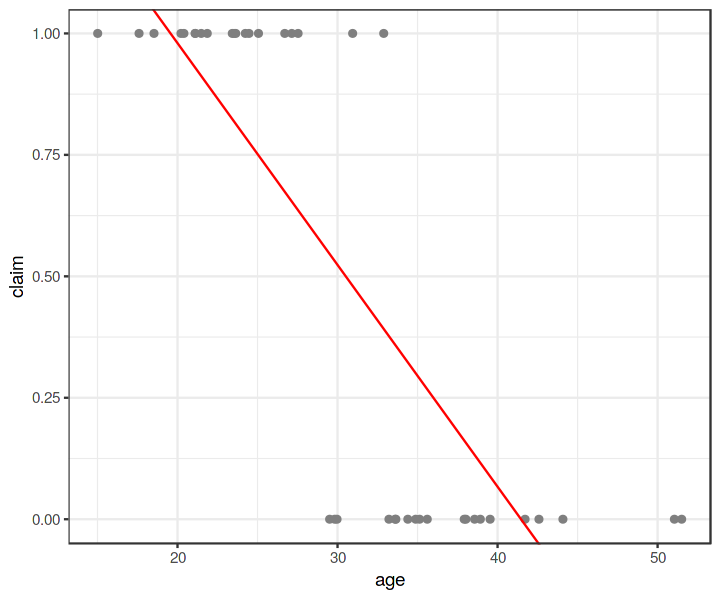

In [4]:
# regress claim on age
lmmod <- lm(claim ~ age, data = insurance)

# plot the data and the regression line
ggplot(data = insurance, aes(x = age, y = claim)) +
    geom_point(color = 'grey50') + 
    geom_abline(intercept = coef(lmmod)[1], slope = coef(lmmod)[2], color = 'red') + 
    theme_bw()

This kind of works, but it's quite awkward. The regression line has captured the fact that older drivers are less likely to file a claim as indicated by the negative slope. But how would we actually decide how to make the classification? We could choose some arbitrary point on the regression line and classify everything above that line as a 1 (claim filed) and everything below it as a 0 (no claim filed). But which point should we choose? Secondly, what about the part of the regression line that goes below 0 on the y axis? A negative value is completely nonsensical in this context. The same is true for any prediction above 1. 

We want to know the probability that the dependent variable is 1 given X:

$$P(y = 1 \mid X)$$,

where X represents the features. For short, let's just call it:

$$P(x)$$



This problem can be solved by combinin the log-odds, the logistic function and the sigmoid function. Let's begin with odds and how they relate to probabilities. One area where you may have encountered odds before is horse racing. Given a probability, we can convert to odds by taking that probability and dividing by 1 minus that probability. This is a ratio of the probability that the event occurs over the probability that the event does not occur:

$$\frac{P(x)}{1-P(x)}$$

Next, note that the log-odds is simpy the natural log of the odds function:

$$\log\left({\frac{P(x)}{1-P(x)}}\right)$$

This function is commonly called the 'logit' function. For logistic regression, we assume that we can express the log-odds, or logit, of the dependent variable as a linear combination of the independent variables (Zumel, 2011):

$$\log\left({\frac{P(x)}{1-P(x)}}\right) = \beta_0X_0 + \beta_1X_1 + ... +  B_jX_j$$

Finally, the last piece of the puzzle is the sigmoid function ("Sigmoid Function", n.d.):

$$\frac{1}{1+e^{-x}}$$


Let's put the sigmoid into code:

In [5]:
sigmoid <- function(x) { 
    
    1 / (1 + exp(-x)) 
    
}

Then we plot the sigmoid for values of x between -5 and 5 for every 0.5 step.

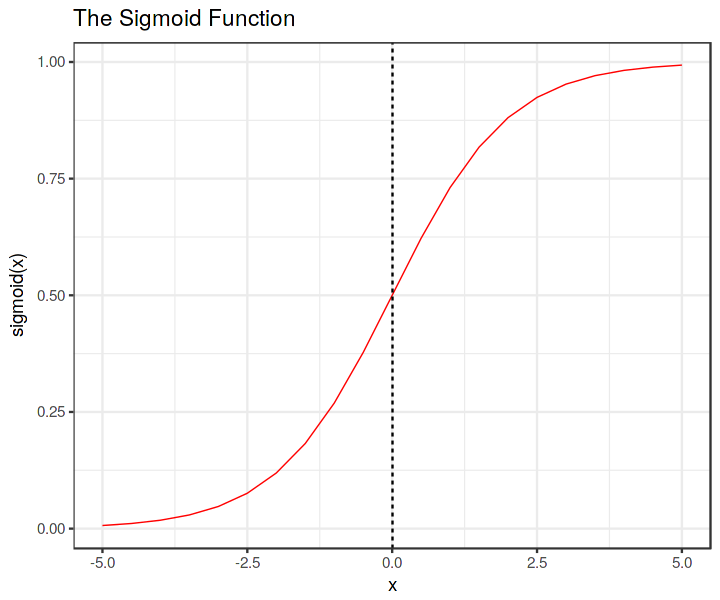

In [6]:
data.frame(x = seq(-5, 5, 0.5), y = sigmoid(seq(-5,5, 0.5))) %>%
    ggplot(aes(x = x, y = y)) + 
    geom_line(color = 'red', size = 0.3) + 
    geom_vline(xintercept = 0, linetype = 'dashed') + 
    labs(y = 'sigmoid(x)', title = 'The Sigmoid Function') + 
    theme_bw()

Notice how well this fits between 0 and 1. Also no matter how far we go along the x-axis in either direction, the function never actually reaches 0 or 1; it is asymptotic. Compare this plot to the one above. Wouldn't it be nice if we could somehow fit something like this sigmoid curve to that data? It turns out that the sigmoid function is the inverse of the log odds function. If you'd like to see the mathematical derivation of this you can find it [here](http://karlrosaen.com/ml/notebooks/logistic-regression-why-sigmoid/). 

So from our equation above,

$$\log\left({\frac{P(x)}{1-P(x)}}\right) = \beta_0X_0 + \beta_1X_1 + ... +  B_jX_j$$

We can derive the following by taking the inverse:

$$P(x) = \frac{1}{1+e^{-\beta_0X_0 + \beta_1X_1 + ... +  B_jX_j}}$$

Therefore, once we model the the log-odds as a linear combination of the features, we can pass the results through the sigmoid function to obtain probabilities. 

The generalized linear model handles this for us. All we have to do is specify the link function that it will use in estimation. The glm will then handle the fitting of the data, which is done by [maximum likelihood](http://mathworld.wolfram.com/MaximumLikelihood.html).  We do so as follows:


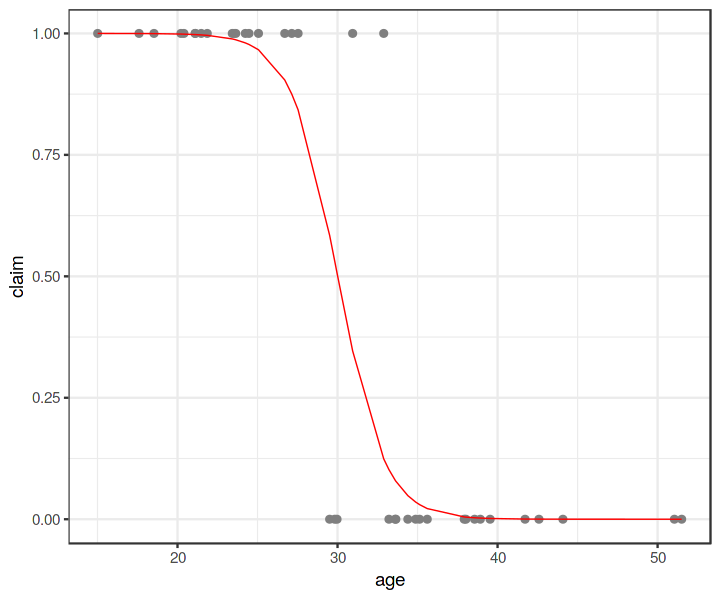

In [7]:
# estimate the logistic regression model
logmod <- glm(claim ~ age, data = insurance, family = binomial(link = 'logit'))

# make predictions on the training data
insurance$preds <- predict(logmod, type = 'response')

# plot results
ggplot(data = insurance, aes(x = age, y = claim)) + 
    geom_point(color = 'grey50') + 
    geom_line(aes(x = age, y = preds), color = 'red', size = 0.3) + 
    theme_bw()

Notice that the curve fit to the data by the model resembles the sigmoid function except that it is reflected about x = 0.5 (and shifted right) due to the relationship between `claim` and `age`. Also the, curve never exceeds 1 or falls below 0, so we can interpret the predicted responses as probabilities. 

# The Porto Competition

Ok enough theory and fake data. Let's get to the Porto Seguro competition. We are going to apply logistic regression to the training data to model claims. In this case the competition hosts are asking for predicted probabilities that each of the customers in the test data filed a claim. We are given 56 anonymized features which we can use to model claims and make predictions. First let's get the data:

In [8]:
dtrain <- read_csv('../input/train.csv', col_types = cols())

We need to do some preprocessing before we build the model. Although the data for this competition are anonymized, we do know that any variable name ending in `_cat` is an unordered categorical variable and that everything ending in `_bin` is a binary variable. Evereything else is considered to be continous. We will want to turn the categorical features into factor variables and then perform one-hot encoding (or dummy variable encoding). If we don't, we will be regressing the `target` variable on numeric data that is largely meaningless. Before we do this however, we need to do something about the missing values lest they screw up our encoding. Missing data is this dataset are written as -1 rather than the standard `NA`. We want to convert these -1's to NA so that any missing categorical data doesn't get encoded as an additional factor level. 

In [9]:
# Set missing values to NA 
dtrain[dtrain == -1] <- NA

# collect the categorical variable names
cat_vars <- names(dtrain)[grepl('_cat$', names(dtrain))]

# convert categorical features to factors
dtrain <- dtrain %>%
    mutate_at(.vars = cat_vars, .funs = as.factor)

# One hot encode the factor variables
dtrain <- model.matrix(~ . - 1, data = dtrain)

Now that that's done, let's split our data into a train and test set. We want a test set with which to build our ROC curve (more on that later) and test the accuracy of our model. Here I split the data, making the training data only 20% of the total observations to cut down on the model training time in this example. You can (and should) certainly use more. 

In [10]:
# set seed for reproducibility
set.seed(123)

# making a train index
train_index <- sample(c(TRUE, FALSE), replace = TRUE, size = nrow(dtrain), prob = c(0.2, 0.8))

# split the data according to the train index
training <- as.data.frame(dtrain[train_index, ])
testing <- as.data.frame(dtrain[!train_index, ])

Often when running logistic regression on larger data sets where we've done a lot of factor encoding we may run into issues with linear dependence among the features. If we try to fit a logistic regression where this is the case, we will get a rank-deficient fit. To alleviate this, we can use the `findLinearCombos` function from the caret package to locate the offending features. Here I run the function and then remove the features as suggested in the `remove` element of the resulting list. 

In [11]:
# find any linear combos in features
lin_comb <- findLinearCombos(training)

# take set difference of feature names and linear combos
d <- setdiff(seq(1:ncol(training)), lin_comb$remove)

# remove linear combo columns
training <- training[, d]

After doing so, I still ran into a problem with the `ps_ind_02_cat4` feature, which is the binary encoding the the fourth factor level in the `ps_ind_02_cat` feature in the original training data. I've been unable as of yet to determine why this one is a problem, but I am just removing it for now. 

In [12]:
training <- training[, setdiff(names(training), 'ps_ind_02_cat4')]

Now we will build our model. For now we are skipping two things - data exploration and feature engineering - in order to focus on the topic at hand. Here we use the `glm` function to to build the model. We do this in much the same way as the `lm` function except that we need to provide the link function that will convert the results to the logit function. 

In [13]:
# estimate logistic regression model on training data
logmod <- glm(target ~ . - id, data = training, family = binomial(link = 'logit'))

This takes a few minutes, but once its done we have our results and we can use it to make probability predictions like so:

In [14]:
# make predictions on the test set
preds <- predict(logmod, newdata = testing, type = "response")

Now we have our predictions, which are a vector of probabilities that each customer filed a claim. Let's take a quick look and see what we've got.

[1] 0.00 0.54
[1] 0.03773773


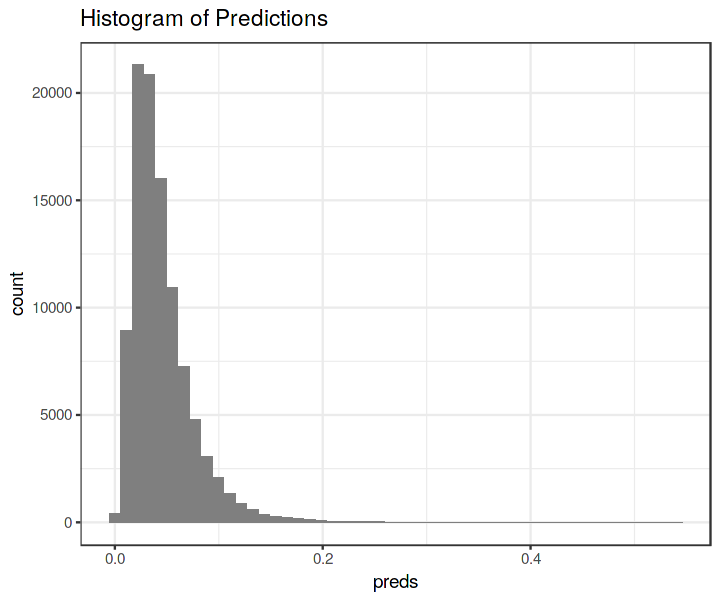

In [15]:
# plot histogram of predictions
data.frame(preds = preds) %>%
    ggplot(aes(x = preds)) + 
    geom_histogram(bins = 50, fill = 'grey50') +
    labs(title = 'Histogram of Predictions') +
    theme_bw()

# print range of predictions
print(round(range(preds),2))

# print median of predictions
print(median(preds))

The predictions range from 0 to 0.54 with a median of only 0.037.

# The ROC Curve

As stated in the introduction, one very common way of assessing the usefulness of a binary classifier is the ROC curve as well as the area under the ROC curve (AUC). The ROC curve is a simple plot that shows the tradeoff between the true positive rate and the false positive rate of a classifier for various choices of the probability threshold. Before we get started on building our own ROC curve and assessing the quality of our logistic regression model, let's take a look at an example borrowed from the University of Nebraska Medical Center's website [here](http://gim.unmc.edu/dxtests/roc3.htm).

![ROC Curve](http://gim.unmc.edu/dxtests/roccomp.jpg)
<center>(credit UNMC)</center><br>


Here we see three ROC curves that are labelled as 'Excellent', 'Good', and 'Worthless'. These represent the results of three different classifiers of various usefulness. The x-axis show the false positive rate (FPR) from 0 to 1 and the y-axis shows the true positive rate (TPR) from 0 to 1. The plotted lines show, for various cutpoints or choices of threshold, what the these rates are. The closer the curve gets to the top left corner the better the classifier. Notice that a perfect classifier would yield a true positive rate of 1 and a false positive rate of 0. In such an ideal case, the ROC curve would be a straight line from (0,0) to (0,1) and a horizontal line from (0,1) to (1,1). This is why the area under the curve is used as a singular measure for assessing the usefulness of a classifier. For a perfect classifier the area under the ROC curve would be 1:

$$1TPR \times 1 FPR$$

Notice that blue classifer labeled 'worthless'. It is essentially the 45 degree line or the line that starts at (0,0) and has slope 1. This classifier has an area under curve of 0.5 and is considered not of use because it is no better than random guessing. If our curve goes under the 45 degree line (i.e. the AUC is less than 0.5) then we know we've done something wrong because then our model would perform worse than random guessing!

That's the general idea. Let's build our own ROC curve for our predictions for the Porto competition that we just generated. The first thing that we need to do is determine how many cutpoints that we want to use. I'll keep this small in number for sake of example. Because our predictions range from 0 to 0.54, we'll select cut points within this range. Here I am choosing thresholds of 0.3, 0.2, 0.1, 0.05, 0.04, 0.03, 0.02, and  0.01. Fore each one of these cut points were are going to classify everything above the cut point as the positive class (1 in this case) and everything below as the negative class (0 in this case). Here I do so, putting the results into a dataframe. 

In [16]:
roc_data <- data.frame(
    p0.3 = ifelse(preds > 0.3, 1, 0),
    p0.2 = ifelse(preds > 0.2, 1, 0),
    p0.1 = ifelse(preds > 0.1, 1, 0),
    p0.05 = ifelse(preds > 0.05, 1, 0),
    p0.04 = ifelse(preds > 0.04, 1, 0),
    p0.03 = ifelse(preds > 0.03, 1, 0),
    p0.02 = ifelse(preds > 0.02, 1, 0),
    p0.01 = ifelse(preds > 0.01, 1, 0))

Now that we've done that, we need to calculate the true positive rate and false positive rate for each threshold. Because we'll need to caclulate these multiple times, I've created function to calculate the true positive rate, `tpr()`, and the false positive rate `fpr()`. 

In [17]:
# true positive (hit) rate
tpr <- function(pred, actual) {
    res <- data.frame(pred, actual)
    sum(res$actual == 1 & res$pred == 1) / sum(actual == 1)
}

# false positive rate
fpr <- function(pred, actual) {
    res <- data.frame(pred, actual)
    sum(res$actual == 0 & res$pred == 1) / sum(actual == 0)
}

Next we get the true labels from the test data and save them to a variable named `actual` for convenience. 

In [18]:
# get actual values from testing data
actual <- testing$target

Now we take the ROC data frame and reshape it from 'wide' to 'long' format using the threshold values as the key. We do this so that we can use `dplyr`'s `group_by()` function and `summarize` function, passing in our `tpr()` and `fpr()` functions to get the true positive rate and the false positive rates for each threshold value. 

In [19]:
# reshape to long format and get fpr and tpr for each threshold
roc_data <- roc_data %>% 
    gather(key = 'threshold', value = 'pred') %>% 
    group_by(threshold) %>%
    summarize(tpr = tpr(pred, actual = actual), 
              fpr = fpr(pred, actual = actual))

Now that the data are in the correct format, all we have to do is plot it. We plot a line with the false positive rates on the x-axis and the true positive rates on the y-axis. Then we add a 45 degree line and scale the x and y axes to insure that they go from 0 to 1 exactly. 

Warning message:
“Removed 1 rows containing missing values (geom_text).”

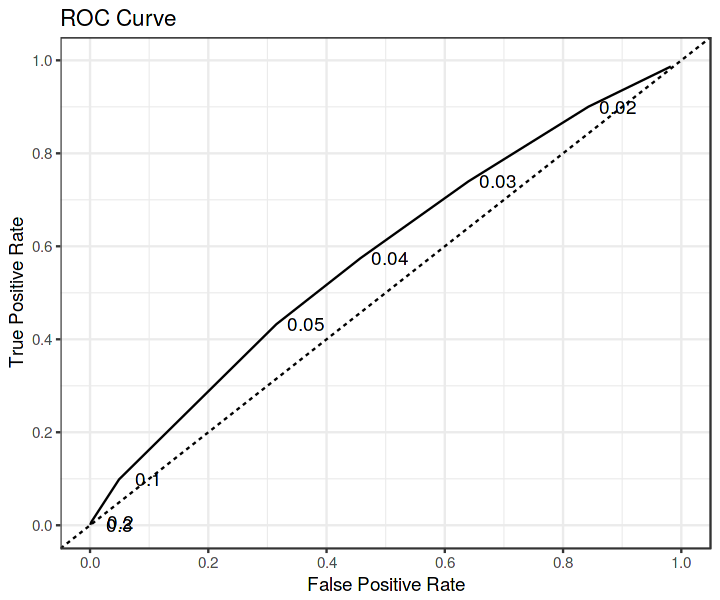

In [20]:
# set x and y tick marks
breaks <-  c(0, 0.2, 0.4, 0.6, 0.8, 1)

# get labels for plotting break points
labels <- substr(roc_data$threshold, start = 2, stop = 5)

# plot the ROC curve
ggplot(data = roc_data, aes(x = fpr, y = tpr)) + 
    geom_line() + 
    geom_text(aes(label = labels), nudge_x = 0.05) + 
    geom_abline(intercept = 0, slope = 1, linetype = 'dashed') + 
    scale_x_continuous(limits = c(0, 1), breaks = breaks) + 
    scale_y_continuous(limits = c(0,1), breaks = breaks) + 
    labs(x = 'False Positive Rate', y = 'True Positive Rate', title = 'ROC Curve') + 
    theme_bw()



Finally we get to see the results of our classification model. The plot shows that our model has a ROC curve that has a higher AUC than the 45 degree line. That's great - we've created a model that does better than random guessing. 

That was an awful lot of work and code to make our ROC plot. I wanted to go through the exercise of doing it from scratch because I feel that doing so greatly improves our understanding of how things work. There are actually several R packages that have functions to plot ROC curves. One of those is the `verification` package, which has the function `roc.plot()`. We can call the function, passing in our actual values, predicted values, and a vector of thresholds to plot like so:

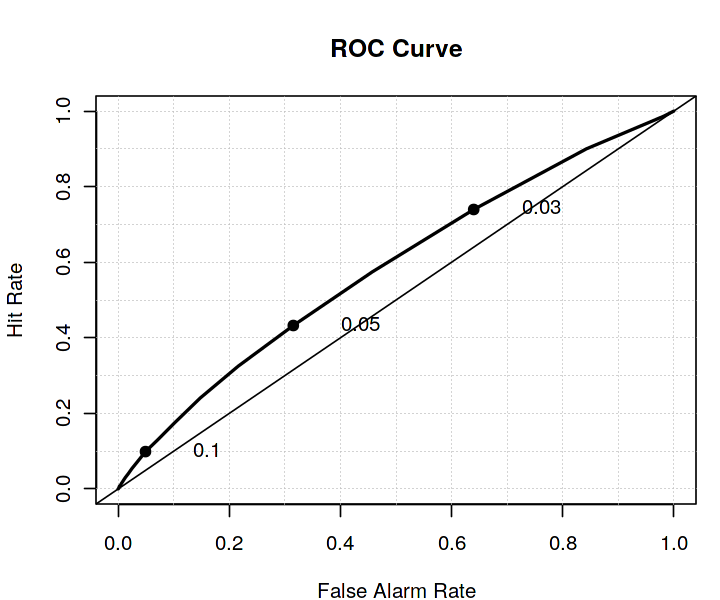

In [21]:
roc.plot(
    testing$target, 
    preds, 
    threshold = seq(0, max(preds), 0.01), 
    plot.thres = c(0.03, 0.05, 0.1))

This generates a ROC curve nearly indentical to the one we created in `ggplot2`. 

# Conclusion

That's it for this kernel. We've gone through the inner working of the logistic regression model and the ROC curve and as a result I hope that you have a better understanding of them. For the Porto competition, logistic regression will certainly not perform as well as other black box classifiers like xgboost and neural networks. However, unlike those types of models, logistic regression yields results that are easy to interpret and explain.

The ROC curve is not only useful for logistic regression results. In fact we can use the ROC curve and the AUC to assess the performance of any _binary_ classifier. 

### References

James, G., Witten, D., Hastie, T., & Tibshiarani, R. An Introduction to Statistical Learning. New York, NY: Springer.

Receiver Operating Characteristic. n.d. In _Wikipedia._ Retrieved October 2, 2017, from https://en.wikipedia.org/wiki/Receiver_operating_characteristic

Sigmoid Function. n.d. In _Wikipedia._ Retreived October 2, 2017, from https://en.wikipedia.org/wiki/Sigmoid_function

Rosaen, K. (2016, May 15). The Sigmoid Function in Logistic Regression. [Blog post]. Retrieved from 
http://karlrosaen.com/ml/notebooks/logistic-regression-why-sigmoid/

Zumel, A. (2011, September 14). The Simpler Derivation of Logistic Regression. [Blog post]. Retrieved from http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/

